In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns


from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer, accuracy_score

In [2]:
long = pd.read_csv('all_stocks_5yr.csv')
long.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [3]:
# using all unique timestamp and closing price as columns for Xs and Y
# company names as row names 

timecol = long['Date'].unique()

dt = long[['Date', 'Close', 'Name']]

# len(dt[dt['Date'] == '2012-08-13'])

In [4]:
# data restructure 

refold = pd.pivot_table(dt, index = 'Name', columns = 'Date', values = 'Close').reset_index()
refold.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.79,59.94,60.20,60.37,60.13,60.87,60.14,59.68,58.57,59.33
1,AAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.44,51.06,50.45,50.55,50.80,50.58,50.00,49.40,48.55,48.35
2,AAP,69.11,70.67,71.30,72.46,72.87,71.58,72.00,72.20,71.96,...,112.01,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34
3,AAPL,90.00,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,148.73,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48
4,ABBV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.91,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63


In [5]:
# replace NaN with row average

ref = refold.T.fillna(refold.mean(axis = 1)).T
ref.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.79,59.94,60.2,60.37,60.13,60.87,60.14,59.68,58.57,59.33
1,AAL,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,...,50.44,51.06,50.45,50.55,50.8,50.58,50,49.4,48.55,48.35
2,AAP,69.11,70.67,71.3,72.46,72.87,71.58,72,72.2,71.96,...,112.01,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34
3,AAPL,90,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,148.73,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48
4,ABBV,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,...,69.91,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63


In [6]:
# save the ticker names to csv

name = pd.DataFrame(ref['Name'])
name.head()
name.to_csv('name.csv', index = False)

In [7]:
# on 2017-08-11, the last recorded date for closing stock price, every company has an entry
# try to predict the trend of closing stock price on 2017-08-11, comparing with the price on 2017-08-10 

sum(ref[ref.columns[-1]].isnull())

# date and price before 8-11 as features and the lables as y

x = ref[ref.columns[1: -1]]


In [26]:
# label stock trend first 

ref['Label'] = np.zeros((ref.shape[0], 1))
ref.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,Label
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.94,60.2,60.37,60.13,60.87,60.14,59.68,58.57,59.33,0.0
1,AAL,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,...,51.06,50.45,50.55,50.8,50.58,50,49.4,48.55,48.35,0.0
2,AAP,69.11,70.67,71.3,72.46,72.87,71.58,72,72.2,71.96,...,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34,0.0
3,AAPL,90,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48,0.0
4,ABBV,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,...,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63,0.0


In [37]:
# 8-11
aug11 = ref.iloc[:, -2]

# 8-10
aug10 = ref.iloc[:, -3]

# labels can be changed according to the desired increase in stock price used in stock selection 

# now label 1 as long as stock price increases from aug 10th to aug 11th 
# and 0 for decreasing stock price

desired_percentage = 0 

for i in range(len(aug10)):
    if (aug11[i] - aug10[i])/ aug10[i] > desired_percentage:
        ref['Label'][i] = 1
    else:
        ref['Label'][i] = 0 
        

C:\Users\1098071\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\1098071\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [38]:
ref.head()

Date,Name,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,...,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,Label
0,A,40.38,40.49,40.48,37.15,37.22,36.68,37.13,37.46,37.47,...,59.94,60.2,60.37,60.13,60.87,60.14,59.68,58.57,59.33,1
1,AAL,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,41.5096,...,51.06,50.45,50.55,50.8,50.58,50,49.4,48.55,48.35,0
2,AAP,69.11,70.67,71.3,72.46,72.87,71.58,72,72.2,71.96,...,114.05,114.48,110.53,111.01,109.49,109.39,109.18,106.13,107.34,1
3,AAPL,90,90.24,90.12,90.91,92.59,95.02,93.72,95.55,94.66,...,150.05,157.14,155.57,156.39,158.81,160.08,161.06,155.32,157.48,1
4,ABBV,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,56.6296,...,70.38,70.71,70.99,70.99,71.22,71.47,72.02,70.44,70.63,1


In [39]:
# check if the classes are balanced 

y = ref.iloc[:, -1]

print(len(y[y == 1]))
print(len(y[y == 0]))

# seems ok, PCA first, then KNN

241
262


# PCA

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 0)

x_mean = np.mean(x, axis = 0)
x_train_norm = x_train - x_mean
x_test_norm = x_test - x_mean


In [41]:
# PCA summary function - where the input variable pca is a PCA object

def pca_summary(pca, standardised_data, out = True):
    names = ["PC" + str(i) for i in range(1, len(pca.explained_variance_ratio_) +  1)]
    a = list(np.std(pca.transform(standardised_data), axis = 0))
    b = list(pca.explained_variance_ratio_)
    c = [np.sum(pca.explained_variance_ratio_[:i]) for i in range(1, len(pca.explained_variance_ratio_) + 1)]
    columns = pd.MultiIndex.from_tuples([("sdev", "Standard deviation"), ("varprop", "Proportion of Variance"), ("cumprop", "Cumulative Proportion")])
    summary = pd.DataFrame(list(zip(a, b, c)), index = names, columns = columns)
    if out:
        print("Importance of components:")
#         display(summary)
    return summary

In [42]:
pca = PCA().fit(x_train_norm)

pca_summary(pca, x_train_norm)

Importance of components:


,sdev,varprop,cumprop
,Standard deviation,Proportion of Variance,Cumulative Proportion
PC1,2.991583e+03,9.506357e-01,0.950636
PC2,4.865658e+02,2.514753e-02,0.975783
PC3,3.220231e+02,1.101504e-02,0.986798
PC4,2.187830e+02,5.084393e-03,0.991883
PC5,1.303453e+02,1.804689e-03,0.993687
PC6,1.136482e+02,1.371946e-03,0.995059
PC7,9.528587e+01,9.644263e-04,0.996024
PC8,7.098698e+01,5.352658e-04,0.996559
PC9,6.789732e+01,4.896856e-04,0.997049


In [43]:
# fit and transform x using PCA(n = 3)
pca = PCA(n_components = 3).fit(x_train_norm)
pcax_train = pca.transform(x_train_norm)

In [15]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

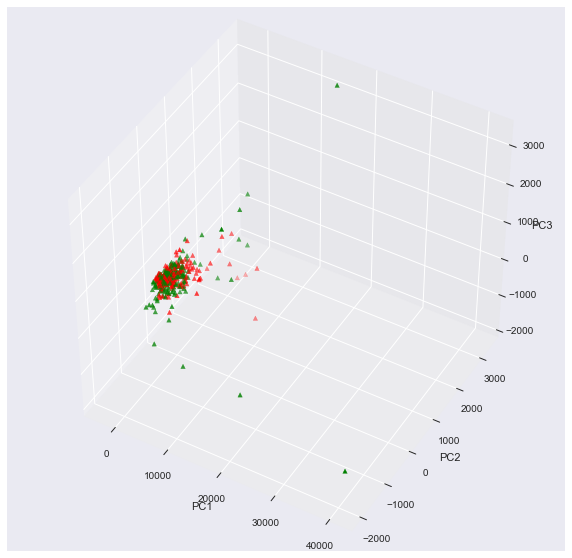

In [44]:
# visualize classes on the new PCA dimension 
# y_train contains true labels 

fig = pylab.figure( figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection = '3d')
color= ['red' if yi == 0 else 'green' for yi in y_train]

sc = ax.scatter(pcax_train[:, 0], pcax_train[:, 1], pcax_train[:, 2], c = color, marker = '^')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Set rotation angle to 30 degrees
# ax.view_init(azim = 150)
# Set the elevation angle 
ax.view_init(elev = 45)

In [179]:
# set elev first and rotate the pic for the best azim

# for ii in xrange(0,360,1):
#     ax.view_init(elev=10., azim=ii)
#     savefig("movie%d.png" % ii)

# KNN

In [45]:
# tuning for the best number of k on training data x after PCA (n = 3 )
# accuracy 

accuracy_rate = make_scorer(accuracy_score)
neighbours = np.arange(1, 10, 2)
accuracy = []

for k in neighbours:
    pca_knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(pca_knn, pcax_train, y_train, cv = 10, scoring = accuracy_rate)
    accuracy.append(scores.mean())
    
neighbours[accuracy.index(min(accuracy))]

9

In [46]:
accuracy

[0.55476235146966846,
 0.5369480925578487,
 0.52006722951844897,
 0.51763133208255163,
 0.51762507817385861]

In [47]:
# tuning for the best number of k on the complete dataset
# accuracy 

fullx = pca.transform(x - x_mean)

accuracy_rate = make_scorer(accuracy_score)
neighbours = np.arange(1, 10, 2)
accuracy_full = []

for k in neighbours:
    pca_knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(pca_knn, fullx, y, cv = 10, scoring = accuracy_rate)
    accuracy_full.append(scores.mean())
    
neighbours[accuracy_full.index(min(accuracy_full))]

3

In [48]:
accuracy_full

[0.53851734539969831,
 0.53271191553544495,
 0.54866968325791854,
 0.53651432880844641,
 0.53839969834087475]

# Evaluation 

In [49]:
pca_knn = KNeighborsClassifier(n_neighbors = 5)
pca_knn.fit(pcax_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
# transform the testing x to the New PC dimension 

pcax_test = pca.transform(x_test_norm)
pred = pca_knn.predict(pcax_test)

print (sum(pred == y_test))
print (sum(pred == y_test)/ len(y_test))

59
0.584158415842


In [51]:
from sklearn.metrics import classification_report

# recall - true positive rate 
# precision - true 

print (classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.66      0.57      0.61        58
          1       0.51      0.60      0.55        43

avg / total       0.60      0.58      0.59       101



In [52]:
# eval on the entire data with KNN(k = 5) and PCA(n = 3)

pcax_full = pca.transform(x - x_mean)
pred5f = pca_knn.predict(pcax_full)

print (sum(pred5f == y))
print (sum(pred5f == y)/ len(y))

349
0.693836978131


In [53]:
type(y_test.iloc[34])


numpy.int64

# Logistic regression


In [54]:
from sklearn.linear_model import LogisticRegression

In [171]:
# logistice regression on ORIGINAL data 

logrorg = LogisticRegression()
logrorg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
logrorg.score(x_test, y_test)

0.65346534653465349

In [176]:
scores = cross_val_score(logrorg, x, y, cv = 10)

print (scores)
print (np.mean(scores))

[ 0.80769231  0.68627451  0.66        0.66        0.66        0.54        0.6
  0.72        0.74        0.68      ]
0.67539668175


In [181]:
sum(logrorg.predict(x_test) == y_test)/ len(y_test)

# prediction for the demeaned testing data 
pred_log_org = logrorg.predict(x_test)
print (classification_report(y_test, pred_log_org))

             precision    recall  f1-score   support

          0       0.70      0.69      0.70        58
          1       0.59      0.60      0.60        43

avg / total       0.65      0.65      0.65       101



In [178]:
tuned_org = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1']}

grid_search_org = GridSearchCV(tuned_org, param_grid, cv= 10, scoring = make_scorer(accuracy_score))
grid_search_org.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [182]:
print (grid_search_org.best_params_.get('C'))
print (grid_search_org.best_params_.get('penalty'))

# fit the tuned logistic regression 

tuned_org = LogisticRegression(C = grid_search_org.best_params_.get('C'), penalty = grid_search_org.best_params_.get('penalty'))
tuned_org.fit(x_train, y_train)

# accuracy on the current testing data 
sum (tuned_org.predict(x_test) == y_test) / len(y_test)

0.001
l2


0.68316831683168322

In [183]:
scores = cross_val_score(tuned_org, x, y, cv = 10)

print (scores)
print (np.mean(scores))

[ 0.76923077  0.70588235  0.68        0.62        0.64        0.56        0.62
  0.82        0.82        0.68      ]
0.691511312217


In [55]:
# logistice regression on PCA data 

logr = LogisticRegression()
logr.fit(pcax_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
# CV score
print (cross_val_score(logr, fullx, y, cv = 10))

# scoring = accuracy_rate seems to be the default scoring here 
np.mean(cross_val_score(logr, fullx, y, cv = 10))

[ 0.59615385  0.58823529  0.64        0.6         0.5         0.5         0.46
  0.66        0.64        0.5       ]


0.5684389140271493

In [57]:
logr.score(pcax_test, y_test)

0.60396039603960394

In [75]:
# logistic regression coefficients 
logr.coef_

array([[ 0.00011813, -0.00067711,  0.00106335]])

In [59]:
sum(logr.predict(pcax_test) == y_test)/ len(y_test)

# prediction for the demeaned testing data 
pred_log = logr.predict(pcax_test)
print (classification_report(y_test, pred_log))

             precision    recall  f1-score   support

          0       0.63      0.74      0.68        58
          1       0.55      0.42      0.47        43

avg / total       0.60      0.60      0.59       101



In [60]:
# support 

len(y_test[y_test== 0])
len(y_test[y_test== 1])

43

In [61]:
# tune Logistic Regression?
# in scikit learn logistic regression, C = 1/lambda, for the consistency with SVM
# i.e. samller C, greater the effect of regularizatoin 

tuned = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1']}

grid_search= GridSearchCV(tuned, param_grid, cv= 10, scoring = make_scorer(accuracy_score))
grid_search.fit(pcax_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [62]:
print (grid_search.best_params_.get('C'))
print (grid_search.best_params_.get('penalty'))

# fit the tuned logistic regression 

tuned = LogisticRegression(C = grid_search.best_params_.get('C'), penalty = grid_search.best_params_.get('penalty'))
tuned.fit(pcax_train, y_train)

# accuracy on the current testing data 
sum (tuned.predict(pcax_test) == y_test) / len(y_test)

1
l1


0.60396039603960394

In [76]:
# CV score on the tuned Logistic regression 
cross_validate = cross_val_score(tuned, fullx, y, cv = 10, scoring = make_scorer(accuracy_score))

print (cross_validate)
print (np.mean(cross_validate))

[ 0.61538462  0.58823529  0.62        0.58        0.5         0.52        0.46
  0.66        0.66        0.52      ]
0.57236199095


## generate the list of companies with prediction probabilities 
- check if the match the reality as well

In [99]:
# predict labels 
predict = tuned.predict(pcax_test)
predict

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

In [89]:
# x_test.iloc[:1]

Date,2012-08-13,2012-08-14,2012-08-15,2012-08-16,2012-08-17,2012-08-20,2012-08-21,2012-08-22,2012-08-23,2012-08-24,...,2017-07-28,2017-07-31,2017-08-01,2017-08-02,2017-08-03,2017-08-04,2017-08-07,2017-08-08,2017-08-09,2017-08-10
90,41.74,41.62,42.3,43.22,43.33,43.12,42.28,42.76,41.35,41.52,...,28.99,29.35,29.22,28.72,30.71,32.21,31.93,31.49,31.88,30.76


In [96]:
# print (name[name.index.values == 90])

# print (ref[ref['Name'] == 'CF'])


# the indices from name lsit and ref, x_test match with each other 

In [100]:
# prediction probability from the tuned logistic regression
# - the second column is the probability of Y = 1 

pofone = tuned.predict_proba(pcax_test)[:, 1]
pofone

array([ 0.46412346,  0.48029291,  0.53605564,  0.42048188,  0.51585787,
        0.48210087,  0.47136819,  0.49008513,  0.49327333,  0.40747651,
        0.56790284,  0.39010666,  0.55702915,  0.52511392,  0.40575418,
        0.48283667,  0.53053866,  0.36472319,  0.63134372,  0.9539012 ,
        0.93332317,  0.4034376 ,  0.46856271,  0.48328616,  0.59392799,
        0.29168612,  0.48430085,  0.46581172,  0.68619338,  0.61978651,
        0.49301432,  0.47083458,  0.44773061,  0.45193281,  0.47566185,
        0.49434331,  0.42599732,  0.55949505,  0.45926523,  0.46237647,
        0.38725689,  0.11453226,  0.46891721,  0.39719979,  0.4703028 ,
        0.44147163,  0.64918125,  0.48707953,  0.47853799,  0.5399011 ,
        0.4671748 ,  0.51259454,  0.59625163,  0.38449406,  0.47823036,
        0.69812933,  0.37444813,  0.4172064 ,  0.43037346,  0.46186919,
        0.45330043,  0.56528973,  0.60391123,  0.67801821,  0.60043726,
        0.71346502,  0.48632268,  0.49845938,  0.4338904 ,  0.45

In [160]:
# new dataframe of name, predicted label, predicted probability, actual label

# name 
test_name = name.iloc[x_test.index.values]
# predict labels
predict 
# predict probabilities 
pofone
# actual label
y_test

last = pd.DataFrame({'Name': test_name['Name'], 'pred_label': predict, 'pred_prob': pofone, 'actual_label': y_test})
last.sort_values(by = ['pred_prob'], inplace = True, ascending = False)
last.head()

,Name,actual_label,pred_label,pred_prob
56,AZO,1,1,0.976353
37,AMZN,1,1,0.953901
208,GOOGL,1,1,0.933323
336,NOC,0,1,0.768283
302,MCK,0,1,0.722731


In [161]:
last.to_csv('complete.csv')

In [167]:
match = last[last['actual_label'] == last['pred_label']]
matchedandincrease = match[match['pred_label'] == 1]
matchedandincrease.sort_values(by = ['pred_prob'], inplace = True, ascending = False)
print(matchedandincrease.shape)

matchedandincrease 


(18, 4)


C:\Users\1098071\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Name,actual_label,pred_label,pred_prob
56,AZO,1,1,0.976353
37,AMZN,1,1,0.953901
208,GOOGL,1,1,0.933323
245,INCY,1,1,0.713465
12,ADS,1,1,0.698129
428,SWKS,1,1,0.678018
456,UNH,1,1,0.649181
154,EA,1,1,0.631344
236,HSIC,1,1,0.619787
303,MCO,1,1,0.600437


In [163]:
matchedandincrease.to_csv('matchedandincrease.csv')

In [158]:
suggest = last[last['pred_label'] == 1][['Name', 'pred_prob']]
print (suggest.shape)

# rank the suggested comapnies by predicted probabilities 
suggest.sort_values(by = ['pred_prob'], inplace = True, ascending = False)
suggest.head()

(33, 2)


,Name,pred_prob
56,AZO,0.976353
37,AMZN,0.953901
208,GOOGL,0.933323
336,NOC,0.768283
302,MCK,0.722731


In [164]:
suggest.to_csv('suggest.csv')

In [64]:
print (classification_report(y_test, tuned.predict(pcax_test)))

             precision    recall  f1-score   support

          0       0.63      0.74      0.68        58
          1       0.55      0.42      0.47        43

avg / total       0.60      0.60      0.59       101



# Naive Bayes

In [71]:
# naive bayes with PCA data 

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(pcax_train, y_train)

GaussianNB(priors=None)

In [73]:
# CV on PCA data 

scores = cross_val_score(gnb, fullx, y, cv = 10, scoring = accuracy_rate)

print (scores)
print (np.mean(scores))

[ 0.57692308  0.62745098  0.56        0.48        0.52        0.5         0.52
  0.56        0.46        0.48      ]
0.528437405732


# SVM

In [65]:
from sklearn.svm import SVC

In [66]:
# rbf is the default kernel
# SVM on training data with original dimension

clf_svm = SVC()
clf_svm.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [169]:
scores = cross_val_score(clf_svm, x, y, cv = 10, scoring = accuracy_rate)

print (scores)
print (np.mean(scores))

[ 0.51923077  0.52941176  0.52        0.52        0.52        0.52        0.52
  0.52        0.52        0.52      ]
0.520864253394


In [67]:
pred_svm = clf_svm.predict(x_test)

print (classification_report(y_test, pred_svm))

             precision    recall  f1-score   support

          0       0.57      1.00      0.73        58
          1       0.00      0.00      0.00        43

avg / total       0.33      0.57      0.42       101



C:\Users\1098071\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
# if train SVM on the PCAed data 

# rbf is the default kernel
clf_pcasvm = SVC()
clf_pcasvm.fit(pcax_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [170]:
scores = cross_val_score(clf_pcasvm, fullx, y, cv = 10, scoring = accuracy_rate)

print (scores)
print (np.mean(scores))

[ 0.51923077  0.52941176  0.52        0.52        0.52        0.52        0.52
  0.52        0.52        0.52      ]
0.520864253394


In [69]:
pred_pca_svm = clf_pcasvm.predict(pcax_test)

print (classification_report(y_test, pred_pca_svm))

             precision    recall  f1-score   support

          0       0.57      1.00      0.73        58
          1       0.00      0.00      0.00        43

avg / total       0.33      0.57      0.42       101



C:\Users\1098071\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [70]:
# in the full dataset, classses are roughly balanced 
# check if the classes are balanced in testing set as well 

print (len(y_test[y_test == 1]))
print (len(y_test[y_test == 0]))

43
58


**Precision **is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted. It is also called the Positive Predictive Value (PPV).

Precision can be thought of as a measure of a classifiers exactness. A low precision can also indicate a large number of **False Positives.**


**Recall** is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate.

Recall can be thought of as a measure of a classifiers completeness. A low recall indicates many **False Negatives**.